<a href="https://colab.research.google.com/github/haru-ykn/zerotodl/blob/main/ch4_2layernet_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#google drive mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


ゼロから作るDeep Lerning

2層ニューラルネットワークのクラス（4.5.1）

写経

実行環境　Google colabo


In [2]:
import numpy as np
import matplotlib.pyplot as plt


#functions.pyからの呼び出しがうまくいかないので、コードを下記に移植

def identity_function(x):
    return x

def step_function(x):
    return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros_like(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

#gradient.pyを移植

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す

    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)

        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す
        it.iternext()

    return grad

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    #重みの初期化
    self.params = {} #Dic型ネットワークのパラメータを保持する
    #1層目の重み
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    #np.random.randn 平均０の標準偏差１の正規分布をランダムで生成
    #重みをどう設定するかは問題だが、とりあえず、ガウス分布に従う乱数で初期化

    #Generator.standard_normalのほうが高速　使い方を調べて書き換える
    print(self.params['W1'])
    self.params['b1'] = np.zeros(hidden_size)
    #バイアスは０で初期化

    #2層目の重み
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def predict(self, x):
    #推論を行う　ｘは画像データ
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

  #x = 入力データ、ｔ＝教師データ
  def loss(self, x, t):
    y = self.predict(x)

    return cross_entropy_error(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  #重みパラメータに関する勾配を求める
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)
    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads


In [3]:
#load_mnist移植
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
#import numpy as np


#url_base = 'http://yann.lecun.com/exdb/mnist/'
url_base = 'https://ossci-datasets.s3.amazonaws.com/mnist/'  # mirror site

key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

#dataset_dir = os.path.dirname(os.path.abspath(__file__))
dataset_dir = '/content/drive/MyDrive/deep-learning-from-scratch-master'
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:47.0) Gecko/20100101 Firefox/47.0"}
    request = urllib.request.Request(url_base+file_name, headers=headers)
    response = urllib.request.urlopen(request).read()
    with open(file_path, mode='wb') as f:
        f.write(response)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み

    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label :
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか

    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])


if __name__ == '__main__':
    init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [5]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
trans_loss_list = []
train_acc_list = []
test_acc_list = []

#Hyper params
inters_num = 20 #init 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

#epoch当たりの繰り返し数
iter_per_epoch = max(train_size/batch_size,1)

#network
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(inters_num): #range(iters_num)で0から10,000（＝inters_num）までの数字の範囲を返す
  #ミニバッチの取得
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  print(i)

  #勾配の計算
  grad = network.numerical_gradient(x_batch, t_batch)

  #パラメータの更新
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  #学習経過の記録
  loss = network.loss(x_batch, t_batch)
  trans_loss_list.append(loss)

  #1エポックごとに認識精度を計算
  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


[[-0.00130575 -0.01296924 -0.00301835 ... -0.00178388  0.01386255
  -0.00728026]
 [ 0.00203575 -0.00361572 -0.01017361 ...  0.01500419  0.00635136
   0.01990561]
 [-0.00955051 -0.00607751 -0.01170316 ...  0.00572816  0.00924853
   0.00492944]
 ...
 [ 0.00150678  0.00102372  0.00543636 ...  0.01708237 -0.00246599
  -0.01444088]
 [-0.00494249  0.00011508 -0.00815927 ... -0.01344172  0.00176606
  -0.02093189]
 [ 0.00253765  0.00879933  0.02363634 ... -0.01011987  0.012721
   0.01920972]]
0
train acc, test acc | 0.09736666666666667, 0.0982
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


<function matplotlib.pyplot.show(close=None, block=None)>

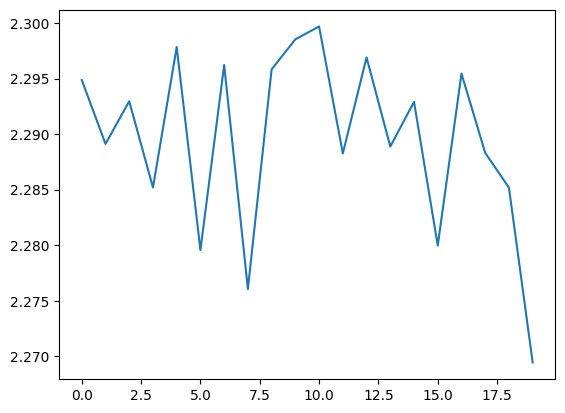

In [10]:
#lossのグラフ化
plt.plot(trans_loss_list)
plt.show
